# MITGCM Event Composition Analysis 

**Purpose**: Code for preforming an event based analysis to explore the features found in the regional space-time spatial scale analysis. The goal here is to get a better physical understanding of the statistical analysis results by exploring what is occuring in the domain during a single event. I will be trying to explain the following two results: 

1. In the along-isobath decorrelation scale space-time $L_s(n,t)$ plot, there is significant variablity (i.e., the system evolves from being dominated by length scales of 30 kilometers to scales of less than 10 kilometers). Why does this occur? 

2. In the cross-isobath decorrelation scale space-time $L_n(s,t)$ plot, the variability 

For the event based analysis, I will create movies of the spatial temperature field in $(s,n)$ space to illustrate how the system evolves. And then I will create snap shots of the spatial field to capture the evolution in a single figure.  

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, compute_decor_scale
from spectra import spectrum1D_frequency
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc, detrend
from structure_functions import compute_structure_function
import stats

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, density

# Set time and space parameters
L            = 1.5                           # Specifies the distance between points (assumes that ds = dn)
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function    
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze
start_time = datetime(2016, 10, 1, 0, 0, 0)  # Specifies the start time of the event period
end_time = datetime(2016, 11, 1, 0, 0, 0)    # Specifies the end time of the event period
event_time_bnds = [start_time, end_time]     # Specifies the event period

# Set path to project directory
PATH = ROOT + 'AirSeaCoupling/data/mitgcm/SWOT_MARA_RUN4_LY/'
PATH_figs =  ROOT + 'AirSeaCoupling/figs_server/mitgcm/scale_analysis/'
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 14

Load intermediate mitgcm data (coordinate transformed)

In [4]:
#--- MITgcm data mapped into (s,n)-space ---# 
if option_var == 'temp':
    filename = PATH + "mitgcm_coord_transform_sn_temp_isobath_2000_res_" + str(L) + ".npz"
elif option_var == 'sal':
    filename = PATH + "mitgcm_coord_transform_sn_sal_isobath_2000_res_" + str(L) + ".npz"
elif option_var == 'density':
    filename = PATH + "mitgcm_coord_transform_sn_rho_isobath_2000_res_" + str(L) + ".npz"

# Load data 
data_struct = np.load(filename, allow_pickle=True)

# Extract data variables
s_coord    = data_struct["s"]
n_coord    = data_struct["n"]
time       = data_struct["time"]
data       = data_struct["data"]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

# Grab data from the event time period
idx_time = (time_dt >= event_time_bnds[0]) & (time_dt <= event_time_bnds[1])
time_event = time_dt[idx_time]
data_event = data[idx_time,:,:]

#--- Decorrelation Length Scale data  ---# 
if option_var == 'temp':
    filename_along = PATH + "mitgcm_along_isobath_decorr_scale_temp.npz"
    filename_cross = PATH + "mitgcm_cross_isobath_decorr_scale_temp.npz"
elif option_var == 'sal':
    filename_along = PATH + "mitgcm_along_isobath_decorr_scale_sal.npz"
    filename_cross = PATH + "mitgcm_cross_isobath_decorr_scale_sal.npz"
elif option_var == 'density':
    filename_along = PATH + "mitgcm_along_isobath_decorr_scale_rho.npz"
    filename_cross = PATH + "mitgcm_cross_isobath_decorr_scale_rho.npz"

# Load data 
data_struct_along = np.load(filename_along, allow_pickle=True)
data_struct_cross = np.load(filename_cross, allow_pickle=True)

# Extract data variables
n_scale    = data_struct_along["n"]
time_scale = data_struct_along["time"]
Ls         = data_struct_along["delta_s"]
Ls_mt      = data_struct_along["delta_s_mt"]
Ls_stdmt    = data_struct_along["delta_s_stdmt"]
Ls_mn      = data_struct_along["delta_s_mn"]
Ls_stdmn   = data_struct_along["delta_s_stdmn"]

s_scale    = data_struct_cross["n"]
time_scale = data_struct_cross["time"]
Ln         = data_struct_cross["delta_n"]
Ln_mt      = data_struct_cross["delta_n_mt"]
Ln_stdmt    = data_struct_cross["delta_n_stdmt"]
Ln_ms      = data_struct_cross["delta_n_ms"]
Ln_stdms   = data_struct_cross["delta_n_stdms"]

# Grab data from the event time period
idx_time = (time_scale >= event_time_bnds[0]) & (time_scale <= event_time_bnds[1])
time_scale_event = time_scale[idx_time]
Ls_event = Ls[idx_time,:]
Ln_event = Ln[idx_time,:]

Ls_mn_event    = Ls_mn[idx_time]
Ls_stdmn_event = Ls_stdmn[idx_time]

Ln_ms_event    = Ln_ms[idx_time]
Ln_stdms_event = Ln_stdms[idx_time]

Plot the spatial domain for the gridded data

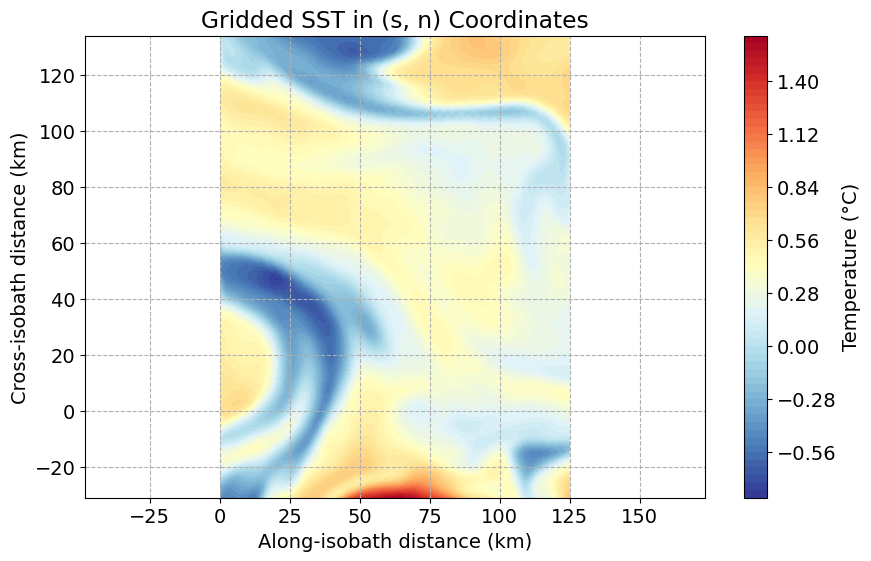

In [5]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set plotting parameters
S, N = np.meshgrid(s_coord, n_coord)

# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.contourf(s_coord, n_coord, data_event[1,:,:].T, cmap='RdYlBu_r',levels=60)

# Set figure attributes
plt.title('Gridded SST in (s, n) Coordinates')
plt.xlabel('Along-isobath distance (km)')
plt.ylabel('Cross-isobath distance (km)')
plt.colorbar(label='Temperature (°C)')
plt.grid(True,linestyle='--')
plt.axis('equal')

# Show the plot
plt.show()

# Save figure
fig.savefig(fname = PATH_figs + 'Temperature_sn_map', bbox_inches = 'tight', dpi=300)

Plot the along- and cross-isobath decorrelation length scale

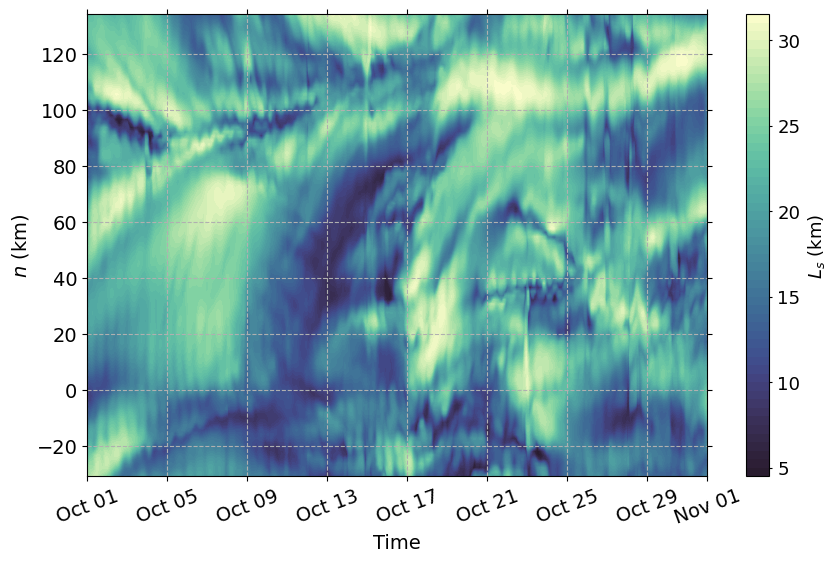

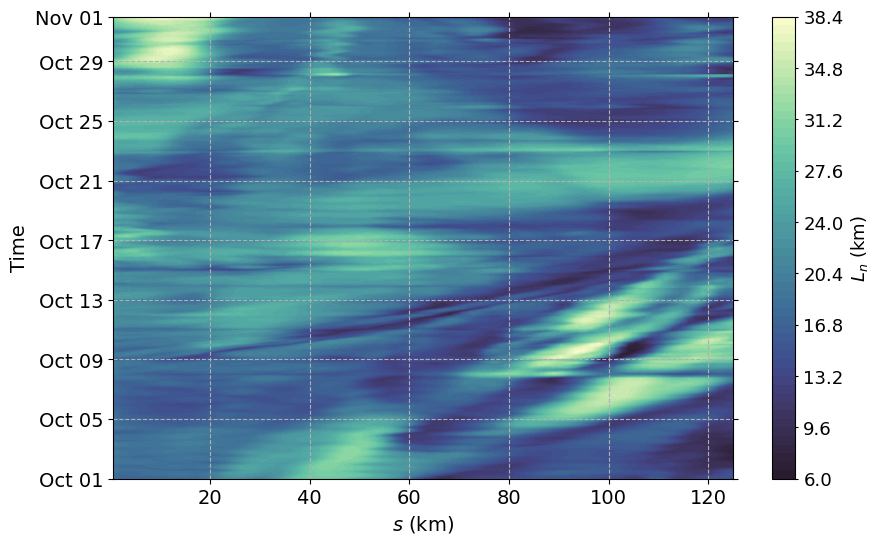

In [6]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(10, 6))

# Plot 
mesh = ax.contourf(time_scale_event, n_scale, Ls_event.T, cmap=cmocean.cm.deep_r,levels=60)

# Set figure attributes
ax.set_xlabel('Time')
ax.set_ylabel(r'$n$ (km)')
plt.setp(ax.get_xticklabels(), rotation=20)
ax.grid(True,linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Set colorbar
cb = fig.colorbar(mesh, orientation='vertical')
cb.set_label(r"$L_s$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(5, 30+5, 5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

# Show the plot
plt.show()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(10, 6))

# Plot 
mesh = ax.contourf(s_scale, time_scale_event, Ln_event, cmap=cmocean.cm.deep_r,levels=60)

# Set figure attributes
ax.set_xlabel(r'$s$ (km)')
ax.set_ylabel('Time')
ax.grid(True,linestyle='--')
ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Set colorbar
cb = fig.colorbar(mesh, orientation='vertical')
cb.set_label(r"$L_n$ (km)", fontsize=fontsize-1)
#cb.set_ticks(np.arange(5, 35+5, 5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

# Show the plot
plt.show()

Plot a movie of the temperature field and decorrelation scale during the event period

In [9]:
# Set plotting parameters
cmap1 = plt.get_cmap('RdYlBu_r')         # Specifies the colormap of subplot 1
cmap2 = plt.get_cmap(cmocean.cm.deep_r)  # Specifies the colormap of subplot 2
levels1 = np.arange(-1.4, 1.4, 0.01)     # Specifies the contour levels of subplot 1
levels2 = np.arange(5, 30, 0.5)          # Specifies the contour levels of subplot 2
num_frames = len(time_scale_event)       # Specifies the number of frames
frame_step = 1                           # Specifies the number of frames skipped

# Create figure and axes
fig, axes = plt.subplots(1,2, figsize=(14, 6))
suptitle = fig.suptitle(f"{str(time_event[0])}", fontsize=fontsize, x=0.5, y=0.99)
axes = np.atleast_1d(axes)               # Ensure it's always iterable

# Create colorbar axes 
cax1 = fig.add_axes([0.13, 0.91, 0.25, 0.03])  
cax2 = fig.add_axes([0.63, 0.91, 0.25, 0.03]) 

# --- Initialize subplots and colorbars --- #

#--- Subplot 1 ---#

# Plot Temperature field at t = t0
mesh0 = axes[0].contourf(
    s_coord, n_coord, data_event[0, :, :].T,
    levels=levels1, cmap=cmap1, extend='both'
)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, cax=cax1, orientation='horizontal')
cb.set_label(r"Temperature ($^\circ$C)", fontsize=fontsize-1)
cb.set_ticks(np.arange(-1.4,1.4+0.7,0.7))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)
cb.ax.xaxis.set_label_position('top')

# Set axis properties
axes[0].set_xlabel(r'$s$ (km)')
axes[0].set_ylabel(r'$n$ (km)')
axes[0].grid(True, linestyle='--')
axes[0].set_xlim((0,125))
axes[0].set_aspect('equal', adjustable='box')

#--- Subplot 2 ---#

# Plot decorrelation scale at t = t0
mesh0 = axes[1].contourf(
    time_scale_event, n_scale, Ls_event.T,
    levels=levels2, cmap=cmap2, extend='both'
)

# Plot the vertical line identifying the time step 
axes[1].axvline(x=time_scale_event[0], color='k', linestyle='--', linewidth=2)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, cax=cax2, orientation='horizontal')
cb.set_label(r"$L_s$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(5, 30+5, 5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)
cb.ax.xaxis.set_label_position('top')

# Set axis properties
axes[1].set_xlabel('Time')
axes[1].set_ylabel(r'$n$ (km)')
axes[1].grid(True, linestyle='--')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(axes[1].get_xticklabels(), rotation=20)

# Set figure layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# --- Animation update function --- #
def update(frame):

    # Update progress statement
    print(f"Rendering frame {frame}", flush=True)

    # Update figure title 
    suptitle.set_text(f"{str(time_event[frame])}")

    # Clear and plot the temperature field at t = ti
    axes[0].clear()
    mesh1 = axes[0].contourf(
        s_coord, n_coord, data_event[frame, :, :].T,
        levels=levels1, cmap=cmap1, extend='both'
    )

    # Set axis attributes
    axes[0].set_xlabel(r'$s$ (km)')
    axes[0].set_ylabel(r'$n$ (km)')
    axes[0].grid(True, linestyle='--')
    axes[0].set_xlim((0,125))
    axes[0].set_aspect('equal', adjustable='box')

    # Clear and plot the decorrelation field at t = ti
    axes[1].clear()
    mesh2 = axes[1].contourf(
        time_scale_event, n_scale, Ls_event.T,
        levels=levels2, cmap=cmap2, extend='both'
    )

    # Plot the vertical line identifying the time step 
    axes[1].axvline(x=time_scale_event[frame], color='k', linestyle='--', linewidth=2)

    # Set axis attributes
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel(r'$n$ (km)')
    axes[1].grid(True, linestyle='--')
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.setp(axes[1].get_xticklabels(), rotation=20)

    return []

# --- Create animation --- #
ani = FuncAnimation(
    fig, update,
    frames=range(0, num_frames, frame_step),
    blit=False
)

# --- Save animation --- #
writer = FFMpegWriter(fps=5, metadata={'artist': 'Temperature field and along decorrelation scale evolution'})
ani.save(
    PATH_figs + f'event_temp_along_decor_evolution_{str(time_event[0])[:10]}.mp4',
    writer=writer
)

Rendering frame 0


/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_46789/3644292107.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


Rendering frame 0
Rendering frame 1
Rendering frame 2
Rendering frame 3
Rendering frame 4
Rendering frame 5
Rendering frame 6
Rendering frame 7
Rendering frame 8
Rendering frame 9
Rendering frame 10
Rendering frame 11
Rendering frame 12
Rendering frame 13
Rendering frame 14
Rendering frame 15
Rendering frame 16
Rendering frame 17
Rendering frame 18
Rendering frame 19
Rendering frame 20
Rendering frame 21
Rendering frame 22
Rendering frame 23
Rendering frame 24
Rendering frame 25
Rendering frame 26
Rendering frame 27
Rendering frame 28
Rendering frame 29
Rendering frame 30
Rendering frame 31
Rendering frame 32
Rendering frame 33
Rendering frame 34
Rendering frame 35
Rendering frame 36
Rendering frame 37
Rendering frame 38
Rendering frame 39
Rendering frame 40
Rendering frame 41
Rendering frame 42
Rendering frame 43
Rendering frame 44
Rendering frame 45
Rendering frame 46
Rendering frame 47
Rendering frame 48
Rendering frame 49
Rendering frame 50
Rendering frame 51
Rendering frame 52
Ren

In [10]:
# Set plotting parameters
cmap1 = plt.get_cmap('RdYlBu_r')         # Specifies the colormap of subplot 1
cmap2 = plt.get_cmap(cmocean.cm.deep_r)  # Specifies the colormap of subplot 2
levels1 = np.arange(-1.4, 1.4, 0.01)     # Specifies the contour levels of subplot 1
levels2 = np.arange(5, 30, 0.5)          # Specifies the contour levels of subplot 2
num_frames = len(time_scale_event)       # Specifies the number of frames
frame_step = 1                           # Specifies the number of frames skipped

# Create figure and axes
fig, axes = plt.subplots(2,1, figsize=(8, 14))
suptitle = fig.suptitle(f"{str(time_event[0])}", fontsize=fontsize, x=0.5, y=0.9)
axes = np.atleast_1d(axes)               # Ensure it's always iterable

# Create colorbar axes 
cax1 = fig.add_axes([0.77, 0.55, 0.025, 0.3])  
cax2 = fig.add_axes([0.77, 0.13, 0.025, 0.3]) 

# --- Initialize subplots and colorbars --- #

#--- Subplot 1 ---#

# Plot Temperature field at t = t0
mesh0 = axes[0].contourf(
    s_coord, n_coord, data_event[0, :, :].T,
    levels=levels1, cmap=cmap1, extend='both'
)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, cax=cax1, orientation='vertical')
cb.set_label(r"Temperature ($^\circ$C)", fontsize=fontsize-1)
cb.set_ticks(np.arange(-1.4,1.4+0.7,0.7))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

# Set axis properties
axes[0].set_xlabel(r'$s$ (km)')
axes[0].set_ylabel(r'$n$ (km)')
axes[0].grid(True, linestyle='--')
axes[0].set_xlim((0,125))
axes[0].set_aspect('equal', adjustable='box')

#--- Subplot 2 ---#

# Plot decorrelation scale at t = t0
mesh0 = axes[1].contourf(
    s_scale, time_scale_event, Ln_event,
    levels=levels2, cmap=cmap2, extend='both'
)

# Plot the vertical line identifying the time step 
axes[1].axhline(y=time_scale_event[0], color='k', linestyle='--', linewidth=2)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, cax=cax2, orientation='vertical')
cb.set_label(r"$L_n$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(5, 30+5, 5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)

# Set axis properties
axes[1].set_xlabel(r'$s$ (km)')
axes[1].set_ylabel('Time')
axes[1].set_xlim((0,125))
axes[1].grid(True, linestyle='--')
axes[1].yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Get position of both axes
pos1 = axes[0].get_position()
pos2 = axes[1].get_position()

# Define a new width that both axes should use
shared_width = min(pos1.width, pos2.width)

# Set new positions with equal width
axes[0].set_position([pos1.x0, pos1.y0, shared_width, pos1.height])
axes[1].set_position([pos1.x0, pos2.y0, shared_width, pos2.height])

# --- Animation update function --- #
def update(frame):

    # Update progress statement
    print(f"Rendering frame {frame}", flush=True)

    # Update figure title 
    suptitle.set_text(f"{str(time_event[frame])}")

    # Clear and plot the temperature field at t = ti
    axes[0].clear()
    mesh1 = axes[0].contourf(
        s_coord, n_coord, data_event[frame, :, :].T,
        levels=levels1, cmap=cmap1, extend='both'
    )

    # Set axis attributes
    axes[0].set_xlabel(r'$s$ (km)')
    axes[0].set_ylabel(r'$n$ (km)')
    axes[0].grid(True, linestyle='--')
    axes[0].set_xlim((0,125))
    axes[0].set_aspect('equal', adjustable='box')

    # Clear and plot the decorrelation field at t = ti
    axes[1].clear()
    mesh2 = axes[1].contourf(
        s_scale, time_scale_event, Ln_event,
        levels=levels2, cmap=cmap2, extend='both'
    )

    # Plot the vertical line identifying the time step 
    axes[1].axhline(y=time_scale_event[frame], color='k', linestyle='--', linewidth=2)

    # Set axis attributes
    axes[1].set_xlabel(r'$s$ (km)')
    axes[1].set_ylabel('Time')
    axes[1].grid(True, linestyle='--')
    axes[1].yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    return []

# --- Create animation --- #
ani = FuncAnimation(
    fig, update,
    frames=range(0, num_frames, frame_step),
    blit=False
)

# --- Save animation --- #
writer = FFMpegWriter(fps=5, metadata={'artist': 'Temperature field and cross-decorrelation scale evolution'})
ani.save(
    PATH_figs + f'event_temp_cross_decor_evolution_{str(time_event[0])[:10]}.mp4',
    writer=writer
)

Rendering frame 0
Rendering frame 0
Rendering frame 1
Rendering frame 2
Rendering frame 3
Rendering frame 4
Rendering frame 5
Rendering frame 6
Rendering frame 7
Rendering frame 8
Rendering frame 9
Rendering frame 10
Rendering frame 11
Rendering frame 12
Rendering frame 13
Rendering frame 14
Rendering frame 15
Rendering frame 16
Rendering frame 17
Rendering frame 18
Rendering frame 19
Rendering frame 20
Rendering frame 21
Rendering frame 22
Rendering frame 23
Rendering frame 24
Rendering frame 25
Rendering frame 26
Rendering frame 27
Rendering frame 28
Rendering frame 29
Rendering frame 30
Rendering frame 31
Rendering frame 32
Rendering frame 33
Rendering frame 34
Rendering frame 35
Rendering frame 36
Rendering frame 37
Rendering frame 38
Rendering frame 39
Rendering frame 40
Rendering frame 41
Rendering frame 42
Rendering frame 43
Rendering frame 44
Rendering frame 45
Rendering frame 46
Rendering frame 47
Rendering frame 48
Rendering frame 49
Rendering frame 50
Rendering frame 51
Rend

Plot a figure of the spatial-temporal evolution of the decorrelation scale and the time and spatially averaged decorrelation during the event period

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_941/2363258891.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


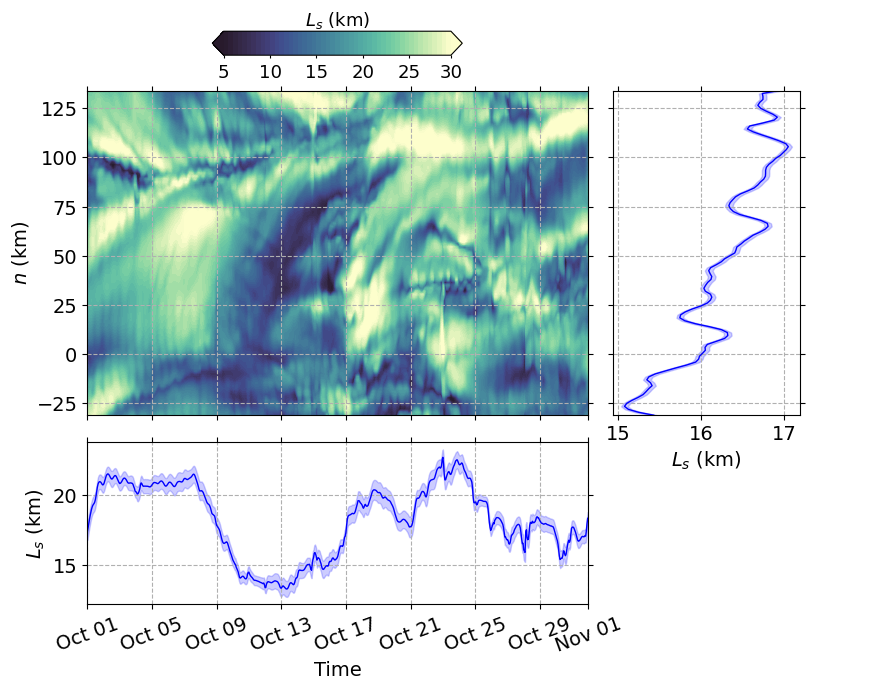

In [7]:
# Set plotting parameters
cmap2 = plt.get_cmap(cmocean.cm.deep_r)  # Specifies the colormap of subplot 2
levels1 = np.arange(-1.4, 1.4, 0.01)     # Specifies the contour levels of subplot 1
levels2 = np.arange(5, 30, 0.5)          # Specifies the contour levels of subplot 2

# Create figure
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 3, height_ratios=[0.5, 4, 2, 0.1], width_ratios=[4, 1.5, 0.3], hspace=0.2, wspace=0.1)

# Create colorbar axes 
cax1 = fig.add_axes([0.25, 0.84, 0.25, 0.03]) 

#--- Subplot 1 ---#
ax1 = fig.add_subplot(gs[1, 0])

# Plot decorrelation scale 
mesh0 = ax1.contourf(
    time_scale_event, n_scale, Ls_event.T,
    levels=levels2, cmap=cmap2, extend='both'
)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, cax=cax1, orientation='horizontal')
cb.set_label(r"$L_s$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(5, 30+5, 5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)
cb.ax.xaxis.set_label_position('top')

# Set axis properties
ax1.set_ylabel(r'$n$ (km)')
ax1.grid(True, linestyle='--')
ax1.set_xticklabels([])
ax1.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

#--- Subplot 2 ---#
ax2 = fig.add_subplot(gs[2, 0])

# Plot the time averaged delta_s
plt.plot(time_scale_event,Ls_mn_event, 'b-', linewidth=1)

# Plot the error bars of the mean autocorrelation function 
plt.fill_between(time_scale_event,Ls_mn_event - Ls_stdmn_event,Ls_mn_event + Ls_stdmn_event,color='b',alpha=0.2)

# Set axis properties
ax2.set_xlabel(r'Time')
ax2.set_ylabel(r'$L_s$ (km)')
ax2.grid(True,linestyle='--')
ax2.set_xlim((np.min(time_scale_event),np.max(time_scale_event)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax2.get_xticklabels(), rotation=20)
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

#--- Subplot 3 ---#
ax3 = fig.add_subplot(gs[1, 1])

# Plot the decorrelation scale
ax3.plot(Ls_mt, n_coord, 'b-', linewidth=1)

# Plot the error bars of the mean autocorrelation function 
ax3.fill_betweenx(n_coord, Ls_mt - Ls_stdmt,Ls_mt + Ls_stdmt,color='b',alpha=0.2)

# Set figure attributes
ax3.set_xlabel(r'$L_s$ (km)')
ax3.grid(True,linestyle='--')
ax3.set_ylim((np.min(n_coord),np.max(n_coord)))
ax3.set_yticks(np.arange(-25,125+25,25))
ax3.set_yticklabels([])
ax3.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Hide unused grid areas
fig.add_subplot(gs[0, 0]).axis("off")
fig.add_subplot(gs[0, 1]).axis("off")
fig.add_subplot(gs[0, 2]).axis("off")
fig.add_subplot(gs[1, 2]).axis("off")
fig.add_subplot(gs[2, 1]).axis("off")
fig.add_subplot(gs[2, 2]).axis("off")
fig.add_subplot(gs[3, 0]).axis("off")
fig.add_subplot(gs[3, 1]).axis("off")
fig.add_subplot(gs[3, 2]).axis("off")

plt.tight_layout()
plt.show()

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_941/4218976516.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


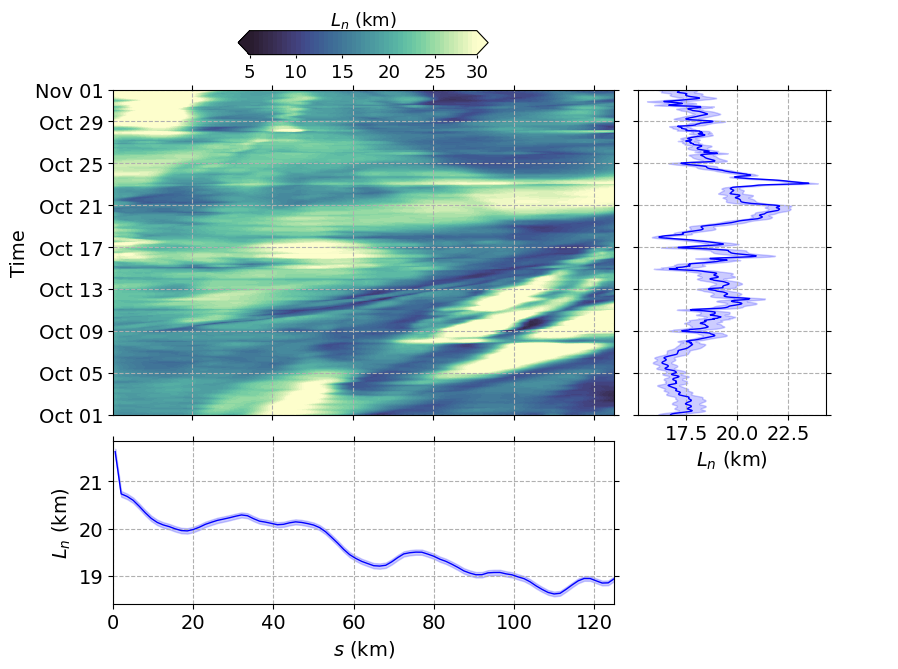

In [8]:
# Set plotting parameters
cmap2 = plt.get_cmap(cmocean.cm.deep_r)  # Specifies the colormap of subplot 2
levels1 = np.arange(-1.4, 1.4, 0.01)     # Specifies the contour levels of subplot 1
levels2 = np.arange(5, 30, 0.5)          # Specifies the contour levels of subplot 2

# Create figure
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 3, height_ratios=[0.5, 4, 2, 0.1], width_ratios=[4, 1.5, 0.3], hspace=0.2, wspace=0.1)

# Create colorbar axes 
cax1 = fig.add_axes([0.25, 0.84, 0.25, 0.03]) 

#--- Subplot 1 ---#
ax1 = fig.add_subplot(gs[1, 0])

# Plot decorrelation scale 
mesh0 = ax1.contourf(
    s_scale, time_scale_event, Ln_event,
    levels=levels2, cmap=cmap2, extend='both'
)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, cax=cax1, orientation='horizontal')
cb.set_label(r"$L_n$ (km)", fontsize=fontsize-1)
cb.set_ticks(np.arange(5, 30+5, 5))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)
cb.ax.xaxis.set_label_position('top')

# Set axis properties
ax1.set_ylabel(r'Time')
ax1.grid(True, linestyle='--')
ax1.set_xticklabels([])
ax1.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

#--- Subplot 2 ---#
ax2 = fig.add_subplot(gs[2, 0])

# Plot the time averaged delta_s
ax2.plot(s_coord,Ln_mt, 'b-', linewidth=1)

# Plot the error bars of the mean autocorrelation function 
ax2.fill_between(s_coord,Ln_mt - Ln_stdmt,Ln_mt + Ln_stdmt,color='b',alpha=0.2)

# Set axis properties
ax2.set_xlabel(r'$s$ (km)')
ax2.set_ylabel(r'$L_n$ (km)')
ax2.grid(True,linestyle='--')
ax2.set_xlim((np.min(s_coord),np.max(s_coord)))
ax2.set_xticks(np.arange(0,120+20,20))
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

#--- Subplot 3 ---#
ax3 = fig.add_subplot(gs[1, 1])

# Plot the decorrelation scale
ax3.plot(Ln_ms_event, time_scale_event, 'b-', linewidth=1)

# Plot the error bars of the mean autocorrelation function 
ax3.fill_betweenx(time_scale_event, Ln_ms_event - Ln_stdms_event,Ln_ms_event + Ln_stdms_event,color='b',alpha=0.2)

# Set figure attributes
ax3.set_xlabel(r'$L_n$ (km)')
ax3.grid(True,linestyle='--')
ax3.set_ylim((np.min(time_scale_event),np.max(time_scale_event)))
ax3.set_yticklabels([])
ax3.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Hide unused grid areas
fig.add_subplot(gs[0, 0]).axis("off")
fig.add_subplot(gs[0, 1]).axis("off")
fig.add_subplot(gs[0, 2]).axis("off")
fig.add_subplot(gs[1, 2]).axis("off")
fig.add_subplot(gs[2, 1]).axis("off")
fig.add_subplot(gs[2, 2]).axis("off")
fig.add_subplot(gs[3, 0]).axis("off")
fig.add_subplot(gs[3, 1]).axis("off")
fig.add_subplot(gs[3, 2]).axis("off")

plt.tight_layout()
plt.show()

Compute a 1D pdf of the along and cross-isobath decorrelation length scales

In [9]:
# Set bin width and edges
bin_width = 0.5
bin_edges = np.arange(0,40+bin_width,bin_width)

# Compute histograms for along and 
_, pdf_Ls, bin_centers_Ls = stats.compute_pdf_1D(Ls_event.flatten(),bin_edges)
_, pdf_Ln, bin_centers_Ln = stats.compute_pdf_1D(Ln_event.flatten(),bin_edges)

# Compute the statistics of each distribution

#--- Along-isobath decorrelation scale ---%
Ls_mean   = np.mean(Ls_event)
Ls_median = np.median(Ls_event)
Ls_perc   = np.percentile(Ls_event, 99)
Ls_std    = np.std(Ls_event,ddof=1)

#--- Cross-isobath decorrelation scale ---%
Ln_mean   = np.mean(Ln_event)
Ln_median = np.median(Ln_event)
Ln_perc   = np.percentile(Ln_event, 99)
Ln_std    = np.std(Ln_event,ddof=1)

Plot histograms

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_941/3388746525.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_941/3388746525.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])


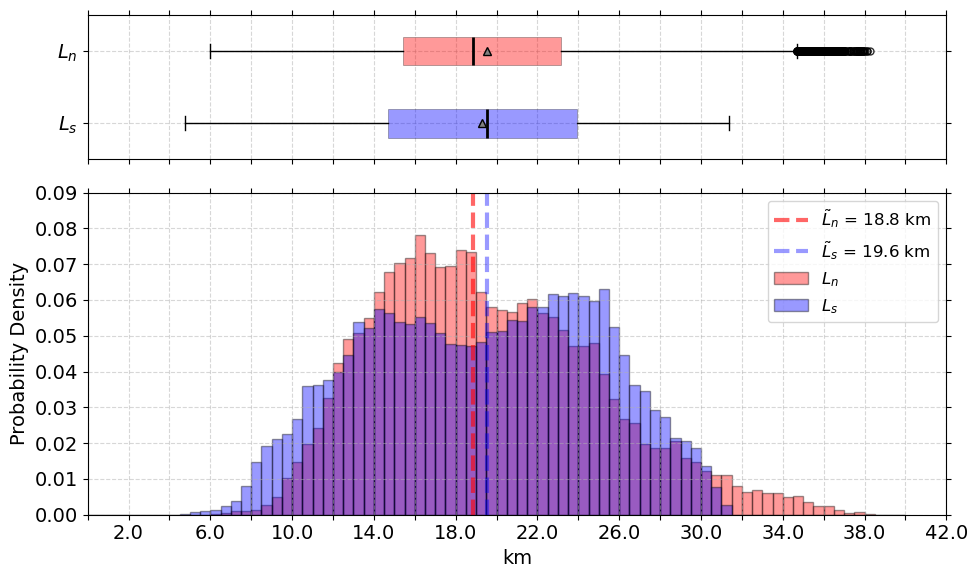

In [10]:
# Create figure
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(3, 1, height_ratios=[1, 1, 1])  # 3 rows, 1 column

# Set axes
ax1 = fig.add_subplot(gs[0])       # Top subplot
ax2 = fig.add_subplot(gs[1:])      # Bottom subplot spans rows 2 and 3

#--- Subplot 1 ---# 

bp = ax1.boxplot([Ls_event.flatten(), Ln_event.flatten()],vert=False, patch_artist=True, widths=0.4, showmeans=True,
            flierprops=dict(marker='o',     
                            markeredgecolor='k',      
                            #markerfacecolor='r',  
                            markersize=5,
                            linestyle='none', 
                            linewidth=0.5,
                            alpha=0.8), 
            medianprops=dict(linestyle='-',linewidth=2,color='k'), 
            boxprops=dict(color='k',          # Edge color
                          facecolor='blue',
                          linewidth=0.5,           # Border thickness
                          linestyle='-',
                          alpha=0.4), 
            whiskerprops=dict(linewidth=1, 
                              color= 'k', 
                              linestyle='-'), 
            meanprops=dict(color='gray',
                           markerfacecolor='gray',
                           markeredgecolor='k',
                           linewidth='0.5'
            ))

# Change individual box colors
colors = ['blue', 'red']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)

# Set figure attributes
ax1.set_xlim((0,42))
ax1.xaxis.set_major_locator(MultipleLocator(2))
xticks = ax1.get_xticks()
ax1.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)
ax1.set_xticklabels([])
ax1.set_yticklabels([r'$L_s$', r'$L_n$'])

#--- Subplot 2 ---# 

# Plot histogram
ax2.bar(bin_centers_Ln, pdf_Ln, width=bin_width, edgecolor='black', color='red', align='center', alpha=0.4, label=r'$L_n$')
ax2.bar(bin_centers_Ls, pdf_Ls, width=bin_width, edgecolor='black', color='blue', align='center', alpha=0.4, label=r'$L_s$')

# Plot statistics
ax2.axvline(Ln_median,color='red',alpha=0.6,linestyle='--',linewidth=3, label=r'$\tilde{L}_n$ = ' + str(np.round(Ln_median,1)) + ' km')
ax2.axvline(Ls_median,color='blue',alpha=0.4,linestyle='--',linewidth=3, label=r'$\tilde{L}_s$ = ' + str(np.round(Ls_median,1)) + ' km')

# Set figure attributes
ax2.set_xlabel(r'km')
ax2.set_ylabel('Probability Density')
ax2.set_xlim((0,42))
ax2.set_ylim((0,0.09))
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_major_locator(MultipleLocator(0.01))
xticks = ax2.get_xticks()
ax2.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
ax2.tick_params(axis='both', labelsize=14)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(fontsize=fontsize-2)
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

plt.tight_layout()
plt.show()

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_65046/1656848836.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])


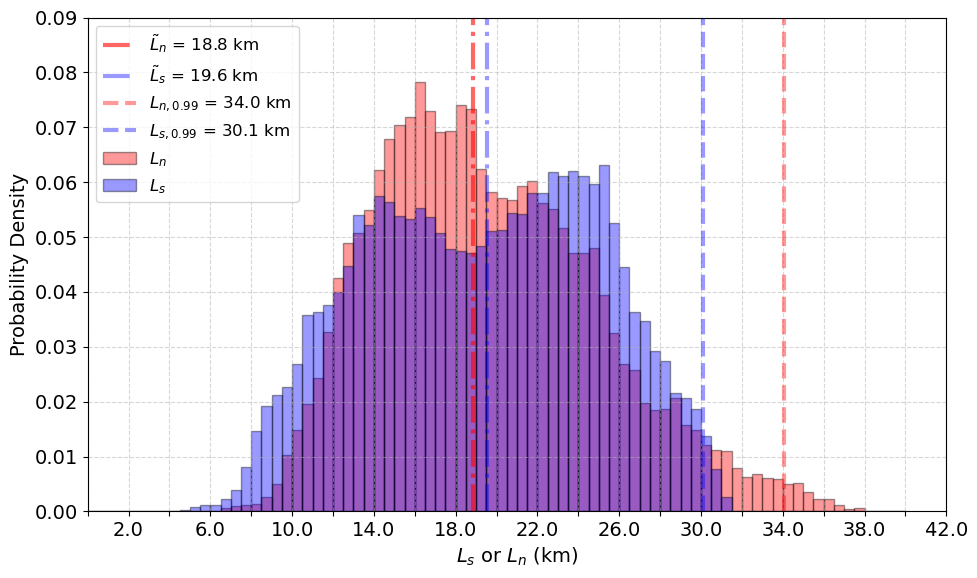

In [23]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(10, 6))

# Plot histogram
ax.bar(bin_centers_Ln, pdf_Ln, width=bin_width, edgecolor='black', color='red', align='center', alpha=0.4, label=r'$L_n$')
ax.bar(bin_centers_Ls, pdf_Ls, width=bin_width, edgecolor='black', color='blue', align='center', alpha=0.4, label=r'$L_s$')

# Plot statistics
#ax.axvline(Ln_mean,color='red',alpha=0.4,linestyle='--',linewidth=3)
#ax.axvline(Ls_mean,color='blue',alpha=0.4,linestyle='--',linewidth=3)

ax.axvline(Ln_median,color='red',alpha=0.6,linestyle='-.',linewidth=3, label=r'$\tilde{L}_n$ = ' + str(np.round(Ln_median,1)) + ' km')
ax.axvline(Ls_median,color='blue',alpha=0.4,linestyle='-.',linewidth=3, label=r'$\tilde{L}_s$ = ' + str(np.round(Ls_median,1)) + ' km')

ax.axvline(Ln_perc,color='red',alpha=0.4,linestyle='--',linewidth=3, label=r'$L_{n,0.99}$ = ' + str(np.round(Ln_perc,1)) + ' km')
ax.axvline(Ls_perc,color='blue',alpha=0.4,linestyle='--',linewidth=3, label=r'$L_{s,0.99}$ = ' + str(np.round(Ls_perc,1)) + ' km')

# Set figure attributes
ax.set_xlabel(r'$L_s$ or $L_n$ (km)')
ax.set_ylabel('Probability Density')
ax.set_xlim((0,42))
ax.set_ylim((0,0.09))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(0.01))
xticks = ax.get_xticks()
ax.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
ax.tick_params(axis='both', labelsize=14)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=fontsize-2)

plt.tight_layout()
plt.show()

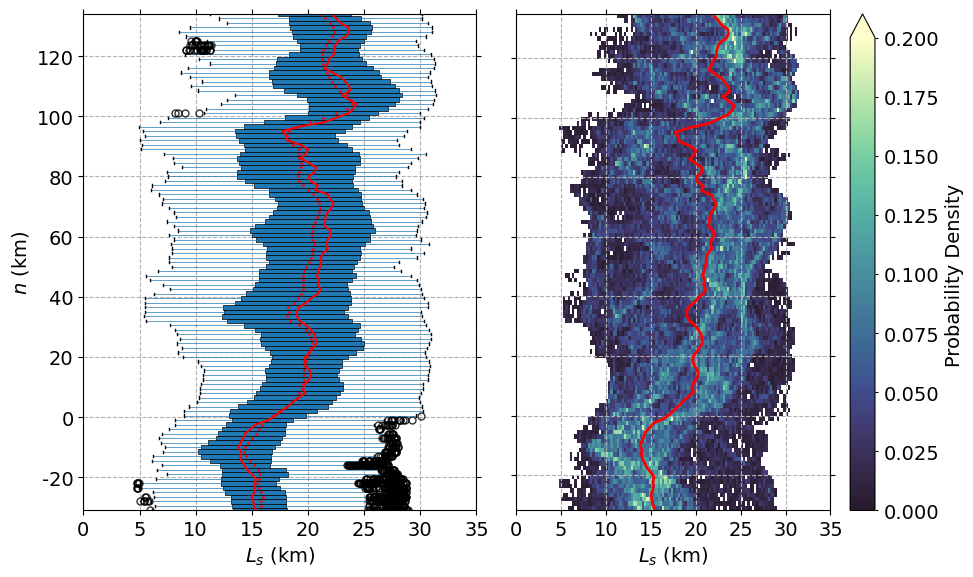

In [11]:
# Set bin width and edges
bin_width = 0.25
bin_edges = np.arange(0,40+bin_width,bin_width)
nbins = len(bin_edges) - 1

# Initialize array
hist_Ls_array = np.zeros((nbins,Ls_event.shape[1]))
pdf_Ls_array  = np.zeros((nbins,Ls_event.shape[1]))
Ls_median_n   = np.zeros((Ls_event.shape[1])) 
Ls_mean_n     = np.zeros((Ls_event.shape[1])) 
Ls_std_n      = np.zeros((Ls_event.shape[1])) 
Ls_stdm_n     = np.zeros((Ls_event.shape[1])) 

# Loop through n-coordinate
for i in range(Ls_event.shape[1]):

    # Obtain the time record at the ith n-coordinate
    iLs = Ls_event[:,i]  

    # Compute statistics
    Ls_mean_n[i] = np.mean(iLs)
    Ls_median_n[i] = np.median(iLs)
    Ls_std_n[i]    = np.std(iLs,ddof=1)
    Ls_stdm_n[i]   = Ls_std_n[i]/np.sqrt(iLs.size)

    # Compute pdf of the ith time record
    hist_Ls, pdf_Ls, bin_centers_Ls = stats.compute_pdf_1D(iLs,bin_edges)
    bin_centers_Ls = np.array(bin_centers_Ls)

    # Convert to float 
    hist_Ls = hist_Ls.astype(float)
    pdf_Ls  = pdf_Ls.astype(float)

    # Set Bins with zero counts to NaN
    idx_zeros_hist          = hist_Ls == 0
    idx_zeros_pdf           = pdf_Ls == 0
    hist_Ls[idx_zeros_hist] = np.nan
    pdf_Ls[idx_zeros_pdf]   = np.nan

    # Save array in a matrix 
    hist_Ls_array[:,i] = hist_Ls
    pdf_Ls_array[:,i] = pdf_Ls

# Set plotting parameters
[BC,NC] = np.meshgrid(bin_centers_Ls,n_coord)
Ls_list = [Ls_event[:,i] for i in range(Ls_event.shape[1])]

# Create figure
fig, ax = plt.subplots(1,2, figsize=(10, 6))

#--- Subplot 1 ---# 
ax1 = ax[0] 

# Plot box plot 
ax1.boxplot(Ls_list, positions=n_coord, vert=False, patch_artist=True, widths=1.5, 
            flierprops=dict(marker='o',     
                            markeredgecolor='k',      
                            #markerfacecolor='r',  
                            markersize=5,
                            linestyle='none', 
                            linewidth=0.5,
                            alpha=0.8), 
            medianprops=dict(linestyle='none'), 
            boxprops=dict(color='k',          # Edge color
                          linewidth=0.5,           # Border thickness
                          linestyle='--'), 
            whiskerprops=dict(linewidth=0.5, 
                              color= '#1f77b4', 
                              linestyle='-'))

# Plot median 
ax1.plot(Ls_median_n,n_coord,color='red',linestyle='-',linewidth=1.5)
ax1.plot(Ls_mean_n,n_coord,'.',color='red',markersize=2)

# Set axis properties
ax1.set_xlabel(r'$L_s$ (km)')
ax1.set_ylabel(r'$n$ (km)')
ax1.set_xticks(np.arange(0,35+5,5))
ax1.set_yticks(np.arange(-20,120+20,20))
ax1.set_xlim((0,35))
ax1.set_ylim((n_coord[0], n_coord[-1]))
ax1.set_yticklabels(['-20', '0', '20', '40', '60', '80', '100', '120'])
ax1.grid(True, linestyle='--')
ax1.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

#--- Subplot 2 ---# 
ax2 = ax[1]

# Plot histogram time as a function of the n-coordinate
mesh0 = ax2.pcolormesh(BC,NC,pdf_Ls_array.T,cmap=cmocean.cm.deep_r,shading='auto',vmin=0, vmax=0.200)

# Plot the median value 
ax2.plot(Ls_median_n,n_coord,color='red',linestyle='-',linewidth=2)

# Set axis properties
ax2.set_xlabel(r'$L_s$ (km)')
ax2.set_xticks(np.arange(0,35+5,5))
ax2.set_xlim((0,35))
ax2.grid(True, linestyle='--')
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)
ax2.set_yticklabels([])
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, orientation='vertical',extend='max')
cb.set_label(r"Probability Density", fontsize=fontsize)
cb.set_ticks(np.arange(0, 0.200 + 0.025, 0.025))
cb.ax.tick_params(length=2.5,labelsize=fontsize)

# Set figure widths
bb1 = ax1.get_position()
bb2 = ax2.get_position()
ax1.set_position([bb1.x0, bb1.y0, bb1.width, bb1.height])
ax2.set_position([bb2.x0, bb2.y0, bb1.width, bb2.height])

# Show plot
plt.tight_layout()
plt.show()

# Plot the decorrelation scale
ax3.plot(Ls_mt, n_coord, 'b-', linewidth=1)

# Plot the error bars of the mean autocorrelation function 
ax3.fill_betweenx(n_coord, Ls_mt - Ls_stdmt,Ls_mt + Ls_stdmt,color='b',alpha=0.2)

In [ ]:
#--- Subplot 2 ---# 
ax2 = ax[1]

# Plot histogram time as a function of the n-coordinate
mesh0 = ax2.pcolormesh(BC,NC,pdf_Ls_array.T,cmap=cmocean.cm.deep_r,shading='auto',vmin=0, vmax=0.200)

# Plot the median value 
ax2.plot(Ls_median_n,n_coord,color='red',linestyle='-',linewidth=2)

# Set axis properties
ax2.set_xlabel(r'$L_s$ (km)')
ax2.set_xticks(np.arange(0,35+5,5))
ax2.set_xlim((0,35))
ax2.grid(True, linestyle='--')
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)
ax2.set_yticklabels([])
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, orientation='vertical',extend='max')
cb.set_label(r"Probability Density", fontsize=fontsize)
cb.set_ticks(np.arange(0, 0.200 + 0.025, 0.025))
cb.ax.tick_params(length=2.5,labelsize=fontsize)

# Set figure widths
bb1 = ax1.get_position()
bb2 = ax2.get_position()
ax1.set_position([bb1.x0, bb1.y0, bb1.width, bb1.height])
ax2.set_position([bb2.x0, bb2.y0, bb1.width, bb2.height])

# Show plot
plt.tight_layout()
plt.show()

# Plot the decorrelation scale
ax3.plot(Ls_mt, n_coord, 'b-', linewidth=1)

# Plot the error bars of the mean autocorrelation function 
ax3.fill_betweenx(n_coord, Ls_mt - Ls_stdmt,Ls_mt + Ls_stdmt,color='b',alpha=0.2)

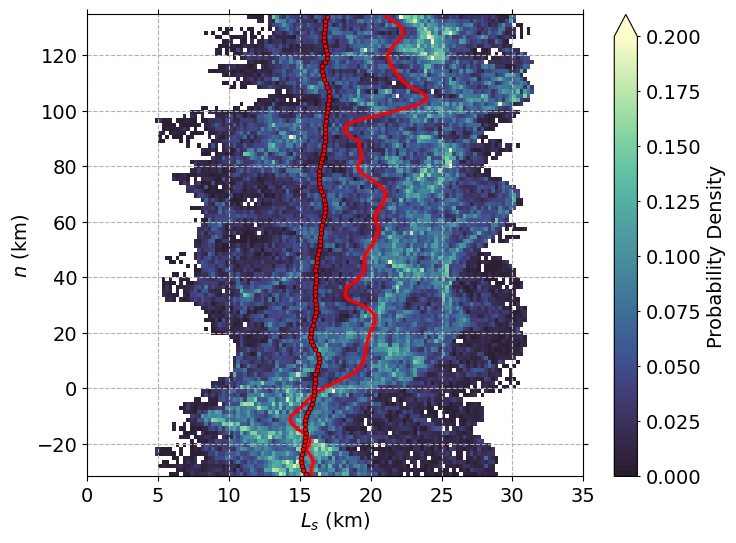

In [ ]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(8, 6))

# Plot histogram time as a function of the n-coordinate
mesh0 = ax.pcolormesh(BC,NC,pdf_Ls_array.T,cmap=cmocean.cm.deep_r,shading='auto',vmin=0, vmax=0.200)

# Plot the median value 
ax.plot(Ls_mean_n,n_coord,color='red',linestyle='-',linewidth=2)
ax.plot(Ls_mt,n_coord,'.',color='red',markersize=7,markeredgecolor='k',markeredgewidth=0.5)

# Plot the standard deviation (NOT the standard error of the mean)
# ax.plot(Ls_mean_n - Ls_std_n,n_coord,color='k',linestyle='-',linewidth=2,alpha=0.3)
# ax.plot(Ls_mean_n + Ls_std_n,n_coord,color='k',linestyle='-',linewidth=2,alpha=0.3)
# ax.fill_betweenx(n_coord, Ls_mean_n - Ls_std_n,Ls_mean_n + Ls_std_n,color='r',alpha=0.2)
# ax.fill_betweenx(n_coord, Ls_mt - Ls_stdmt,Ls_mt + Ls_stdmt,color='r',alpha=0.2)
# ax.fill_betweenx(n_coord, Ls_mean_n - Ls_stdm_n,Ls_mean_n + Ls_stdm_n,color='r',alpha=0.2)

# Set axis properties
ax.set_xlabel(r'$L_s$ (km)')
ax.set_ylabel(r'$n$ (km)')
ax.set_xticks(np.arange(0,35+5,5))
ax.set_xlim((0,35))
ax.grid(True, linestyle='--')
ax.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, orientation='vertical',extend='max')
cb.set_label(r"Probability Density", fontsize=fontsize)
cb.set_ticks(np.arange(0, 0.200 + 0.025, 0.025))
cb.ax.tick_params(length=2.5,labelsize=fontsize)

# Show plot
plt.show()

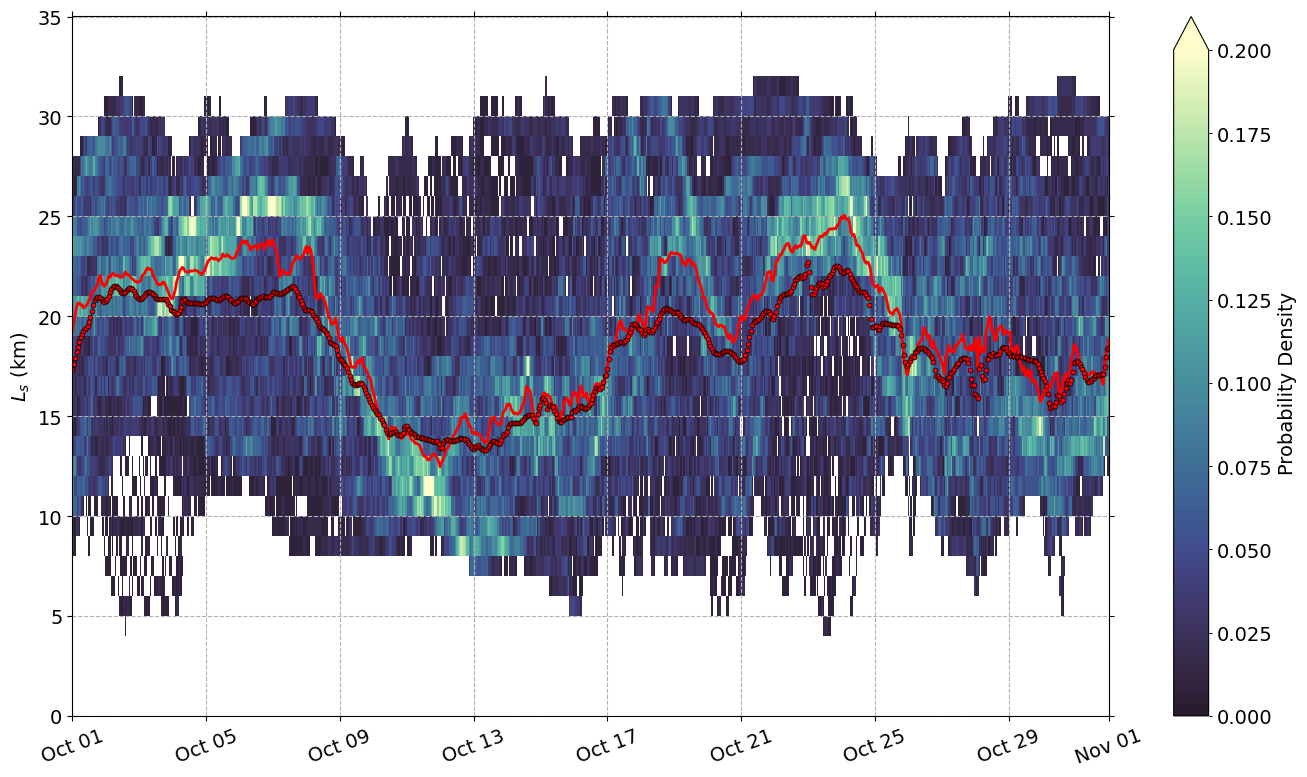

In [101]:
# Set bin width and edges
bin_width = 1
bin_edges = np.arange(0,40+bin_width,bin_width)
nbins = len(bin_edges) - 1

# Initialize array
hist_Ls_array = np.zeros((Ls_event.shape[0],nbins))
pdf_Ls_array  = np.zeros((Ls_event.shape[0],nbins))
Ls_median_n   = np.zeros((Ls_event.shape[0])) 
Ls_mean_n   = np.zeros((Ls_event.shape[0])) 
Ls_std_n   = np.zeros((Ls_event.shape[0])) 

# Loop through n-coordinate
for i in range(Ls_event.shape[0]):

    # Obtain the time record at the ith n-coordinate
    iLs = Ls_event[i,:]  

    # Compute statistics
    Ls_mean_n[i] = np.mean(iLs)
    Ls_median_n[i] = np.median(iLs)
    Ls_std_n[i]    = np.std(iLs,ddof=1)

    # Compute pdf of the ith time record
    hist_Ls, pdf_Ls, bin_centers_Ls = stats.compute_pdf_1D(iLs,bin_edges)
    bin_centers_Ls = np.array(bin_centers_Ls)

    # Convert to float 
    hist_Ls = hist_Ls.astype(float)
    pdf_Ls  = pdf_Ls.astype(float)

    # Set Bins with zero counts to NaN
    idx_zeros_hist          = hist_Ls == 0
    idx_zeros_pdf           = pdf_Ls == 0
    hist_Ls[idx_zeros_hist] = np.nan
    pdf_Ls[idx_zeros_pdf]   = np.nan

    # Save array in a matrix 
    hist_Ls_array[i,:] = hist_Ls
    pdf_Ls_array[i,:] = pdf_Ls

# Set plotting parameters
[TS,BC] = np.meshgrid(time_event,bin_centers_Ls)

# Create figure
fig, ax = plt.subplots(1,1, figsize=(14, 8))

# Plot histogram time as a function of the n-coordinate
mesh0 = ax.pcolormesh(TS,BC,pdf_Ls_array.T,cmap=cmocean.cm.deep_r,shading='auto',vmin=0, vmax=0.200)

# Plot the median value 
ax.plot(time_event,Ls_median_n,color='red',linestyle='-',linewidth=2)
ax.plot(time_event, Ls_mn_event,'.',color='red',markersize=7,markeredgecolor='k',markeredgewidth=0.5)

# Set axis properties
ax.set_ylabel(r'$L_s$ (km)')
ax.set_yticks(np.arange(0,35+5,5))
ax.set_xlim((np.min(time_event),np.max(time_event)))
ax.set_ylim((0,35))
ax.grid(True, linestyle='--')
ax.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax.get_xticklabels(), rotation=20)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, orientation='vertical',extend='max')
cb.set_label(r"Probability Density", fontsize=fontsize)
cb.set_ticks(np.arange(0, 0.200 + 0.025, 0.025))
cb.ax.tick_params(length=2.5,labelsize=fontsize)

# Show plot
plt.tight_layout()
plt.show()

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_46789/3332894547.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


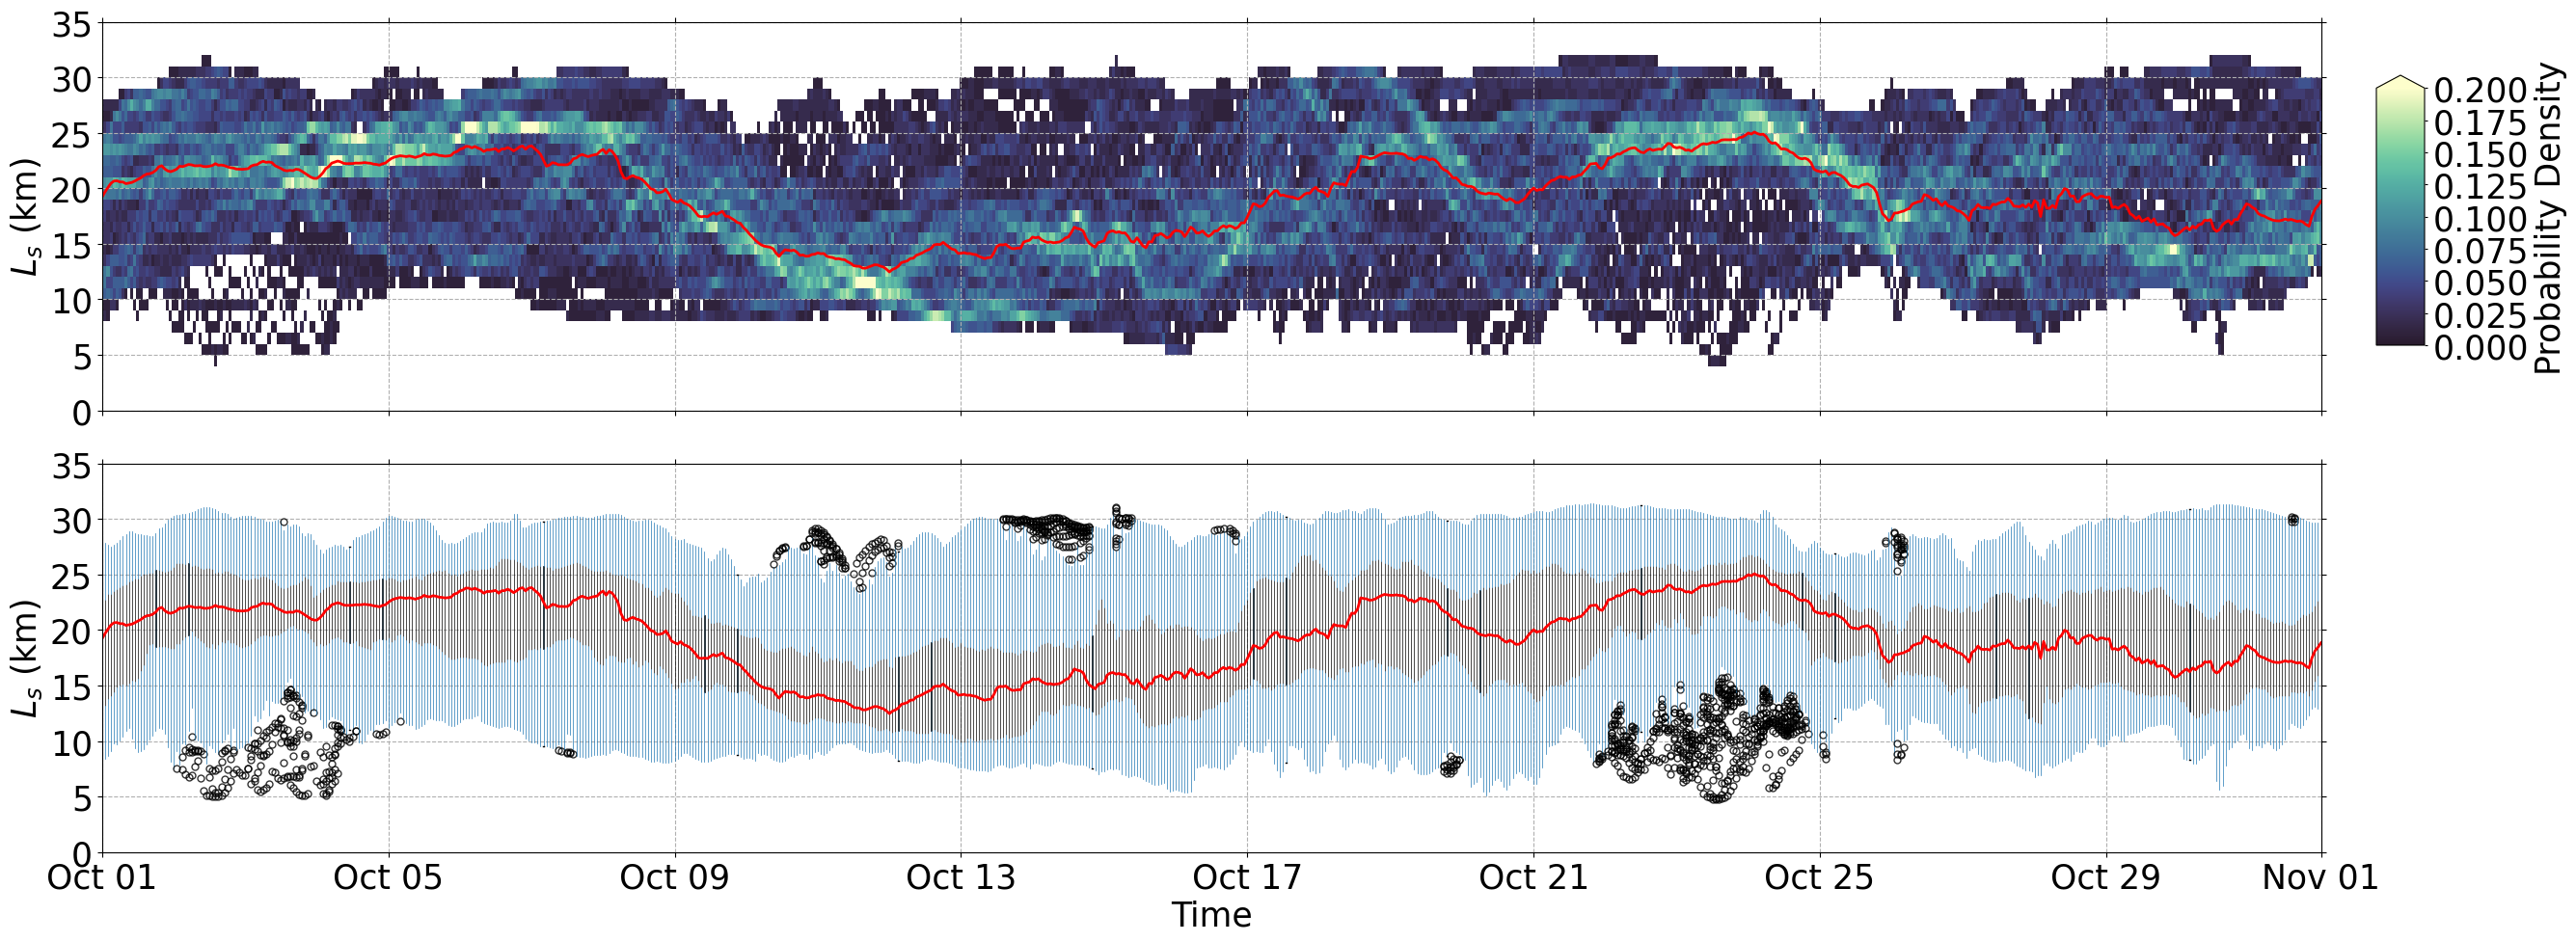

In [ ]:
# Set plotting parameters
[TS,BC] = np.meshgrid(time_event,bin_centers_Ls)
Ls_list = [Ls_event[i,:] for i in range(Ls_event.shape[0])]
fontsize = 25

# Create figure
fig, ax = plt.subplots(2,1, figsize=(25, 10))

# Create colorbar axes 
cax1 = fig.add_axes([0.99, 0.63, 0.02, 0.28])  

#--- Subplot 1 ---# 
ax1 = ax[0] 

# Plot histogram time as a function of the n-coordinate
mesh0 = ax1.pcolormesh(TS,BC,pdf_Ls_array.T,cmap=cmocean.cm.deep_r,shading='auto',vmin=0, vmax=0.200)

# Plot the median value 
ax1.plot(time_event,Ls_median_n,color='red',linestyle='-',linewidth=2)

# Set axis properties
ax1.set_ylabel(r'$L_s$ (km)')
ax1.set_yticks(np.arange(0,35+5,5))
ax1.set_xlim((time_event[0], time_event[-1]))
ax1.set_ylim((0,35))
ax1.grid(True, linestyle='--')
ax1.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax1.get_xticklabels(), rotation=20)
ax1.set_xticklabels([])

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, cax=cax1, orientation='vertical',extend='max')
cb.set_label(r"Probability Density", fontsize=fontsize)
cb.set_ticks(np.arange(0, 0.200 + 0.025, 0.025))
cb.ax.tick_params(length=2.5,labelsize=fontsize)

#--- Subplot 2 ---# 
ax2 = ax[1]

# Set x-axis plotting parameters
reference_time = time_event[0]
time_seconds = np.array([(t - reference_time).total_seconds() for t in time_event])

# Plot box plot 
ax2.boxplot(Ls_list, positions=time_seconds, vert=True, patch_artist=True, widths=30, 
            flierprops=dict(marker='o',     
                            markeredgecolor='k',      
                            #markerfacecolor='r',  
                            markersize=5,
                            linestyle='none', 
                            linewidth=0.5,
                            alpha=0.8), 
            medianprops=dict(linestyle='none'), 
            boxprops=dict(color='k',          # Edge color
                          linewidth=0.5,           # Border thickness
                          linestyle='--'), 
            whiskerprops=dict(linewidth=0.5, 
                              color='#1f77b4', 
                              linestyle='-'))

# Plot median 
ax2.plot(time_seconds,Ls_median_n,color='red',linestyle='-',linewidth=2)

# Set axis properties
ax2.set_xlabel(r'Time')
ax2.set_ylabel(r'$L_s$ (km)')
ax2.set_yticks(np.arange(0,35+5,5))
ax2.grid(True, linestyle='--')
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Copy x-ticks from ax1 (datetime ticks)
shared_ticks_datetime = ax1.get_xticks()

# Remove timezone info from num2date output
shared_ticks_seconds = [(mdates.num2date(t).replace(tzinfo=None) - reference_time).total_seconds()
                        for t in shared_ticks_datetime]

# Set those tick locations in ax2 and label them
ax2.set_xticks(shared_ticks_seconds)
ax2.set_xticklabels([mdates.num2date(t).strftime('%b %d') for t in shared_ticks_datetime])

# Match x-limits with ax1
ax2.set_xlim(time_seconds[0], time_seconds[-1])

# Set fontsize for figure
for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

# Optional: update colorbar tick labels and label
for obj in fig.get_children():
    if isinstance(obj, plt.Axes) and obj.get_label() == '<colorbar>':
        obj.tick_params(labelsize=fontsize)
        obj.yaxis.label.set_size(fontsize)

# Show plot
plt.tight_layout()
plt.show()

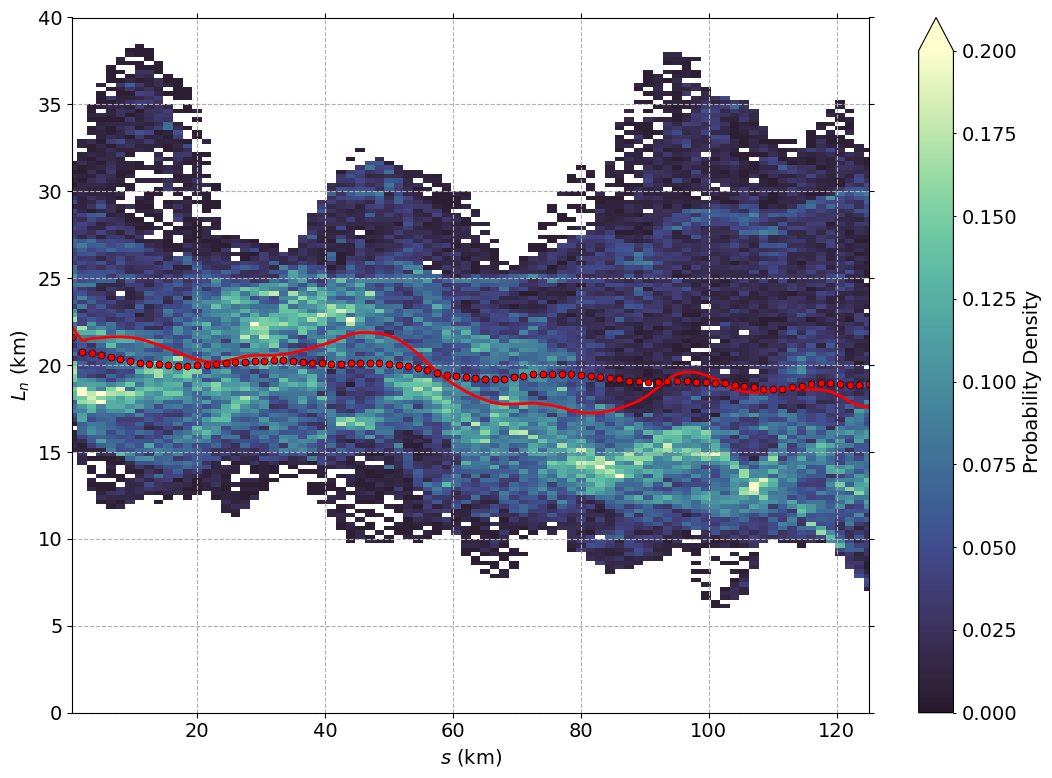

In [16]:
# Set bin width and edges
bin_width = 0.25
bin_edges = np.arange(0,40+bin_width,bin_width)
nbins = len(bin_edges) - 1
fontsize = 14

# Initialize array
hist_Ln_array = np.zeros((nbins,Ln_event.shape[1]))
pdf_Ln_array  = np.zeros((nbins,Ln_event.shape[1]))
Ln_median_n   = np.zeros((Ln_event.shape[1])) 
Ln_mean_n   = np.zeros((Ln_event.shape[1])) 
Ln_std_n   = np.zeros((Ln_event.shape[1])) 

# Loop through s-coordinate
for i in range(Ln_event.shape[1]):

    # Obtain the time record at the ith n-coordinate
    iLn = Ln_event[:,i]  

    # Compute statistics
    Ln_mean_n[i] = np.mean(iLn)
    Ln_median_n[i] = np.median(iLn)
    Ln_std_n[i]    = np.std(iLn,ddof=1)

    # Compute pdf of the ith time record
    hist_Ln, pdf_Ln, bin_centers_Ln = stats.compute_pdf_1D(iLn,bin_edges)
    bin_centers_Ln = np.array(bin_centers_Ln)

    # Convert to float 
    hist_Ln = hist_Ln.astype(float)
    pdf_Ln  = pdf_Ln.astype(float)

    # Set Bins with zero counts to NaN
    idx_zeros_hist          = hist_Ln == 0
    idx_zeros_pdf           = pdf_Ln == 0
    hist_Ln[idx_zeros_hist] = np.nan
    pdf_Ln[idx_zeros_pdf]   = np.nan

    # Save array in a matrix 
    hist_Ln_array[:,i] = hist_Ln
    pdf_Ln_array[:,i] = pdf_Ln

# Set plotting parameters
[SC,BC] = np.meshgrid(s_coord,bin_centers_Ln)

# Create figure
fig, ax = plt.subplots(1,1, figsize=(11, 8))

# Plot histogram time as a function of the n-coordinate
mesh0 = ax.pcolormesh(SC,BC,pdf_Ln_array,cmap=cmocean.cm.deep_r,shading='auto',vmin=0, vmax=0.200)

# Plot the median value 
ax.plot(s_coord,Ln_mean_n,color='red',linestyle='-',linewidth=2)
ax.plot(s_coord,Ln_mt,'.',color='red',markersize=10,markeredgecolor='k',markeredgewidth=0.5)

# Plot the standard deviation (NOT the standard error of the mean)
# ax.plot(s_coord, Ln_mean_n - Ln_std_n,color='k',linestyle='-',linewidth=2,alpha=0.3)
# ax.plot(s_coord, Ln_mean_n + Ln_std_n,color='k',linestyle='-',linewidth=2,alpha=0.3)
# ax.fill_between(s_coord, Ln_mean_n - Ln_std_n,Ln_mean_n + Ln_std_n,color='r',alpha=0.2)

# Set axis properties
ax.set_xlabel(r'$s$ (km)')
ax.set_ylabel(r'$L_n$ (km)')
ax.set_yticks(np.arange(0,40+5,5))
ax.set_xlim((np.min(s_coord),np.max(s_coord)))
ax.set_ylim((0,40))
ax.grid(True, linestyle='--')
ax.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, orientation='vertical',extend='max')
cb.set_label(r"Probability Density", fontsize=fontsize)
cb.set_ticks(np.arange(0, 0.200 + 0.025, 0.025))
cb.ax.tick_params(length=2.5,labelsize=fontsize)

# Show plot
plt.tight_layout()
plt.show()

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_941/2766239918.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


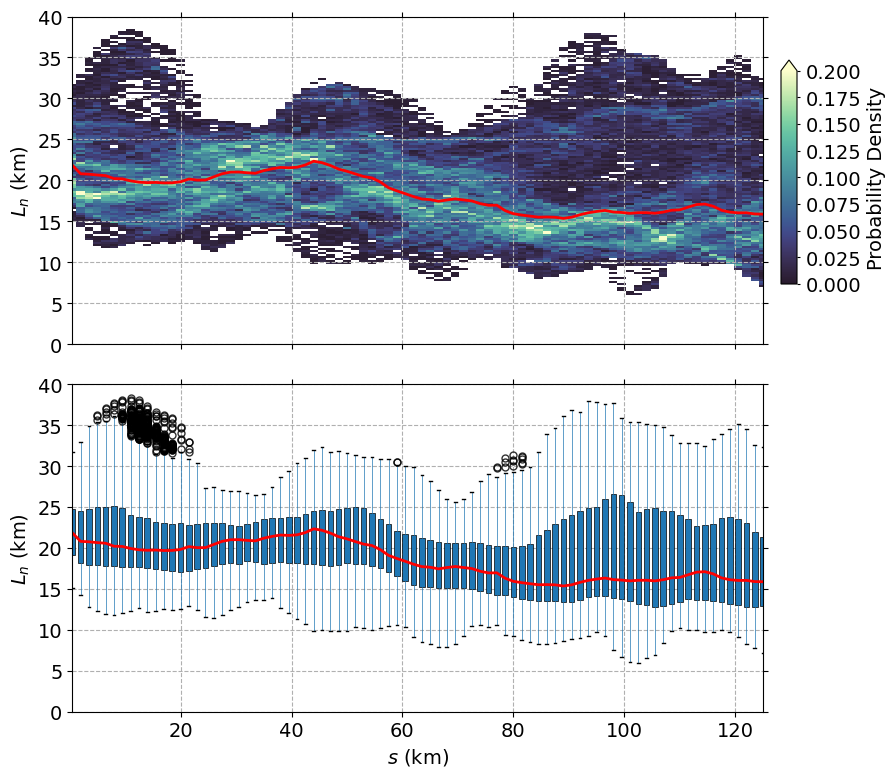

In [17]:
# Set plotting parameters
[SC,BC] = np.meshgrid(s_coord,bin_centers_Ln)
Ln_list = [Ln_event[:,i] for i in range(Ln_event.shape[1])]

# Create figure
fig, ax = plt.subplots(2,1, figsize=(8, 8))

# Create colorbar axes 
cax1 = fig.add_axes([0.99, 0.63, 0.02, 0.28]) 

#--- Subplot 1 ---# 
ax1 = ax[0]

# Plot histogram time as a function of the n-coordinate
mesh0 = ax1.pcolormesh(SC,BC,pdf_Ln_array,cmap=cmocean.cm.deep_r,shading='auto',vmin=0, vmax=0.200)

# Plot the median value 
ax1.plot(s_coord,Ln_median_n,color='red',linestyle='-',linewidth=2)

# Set axis properties
ax1.set_ylabel(r'$L_n$ (km)')
ax1.set_yticks(np.arange(0,40+5,5))
ax1.set_xlim((np.min(s_coord),np.max(s_coord)))
ax1.set_ylim((0,40))
ax1.grid(True, linestyle='--')
ax1.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)
ax1.set_xticklabels([])

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, cax=cax1, orientation='vertical',extend='max')
cb.set_label(r"Probability Density", fontsize=fontsize)
cb.set_ticks(np.arange(0, 0.200 + 0.025, 0.025))
cb.ax.tick_params(length=2.5,labelsize=fontsize)

#--- Subplot 2 ---# 
ax2 = ax[1]

# Plot box plot 
ax2.boxplot(Ln_list, positions=s_coord, vert=True, patch_artist=True, widths=1.0, 
            flierprops=dict(marker='o',     
                            markeredgecolor='k',      
                            #markerfacecolor='r',  
                            markersize=5,
                            linestyle='none', 
                            linewidth=0.5,
                            alpha=0.8), 
            medianprops=dict(linestyle='none'), 
            boxprops=dict(color='k',          # Edge color
                          linewidth=0.5,           # Border thickness
                          linestyle='--'), 
            whiskerprops=dict(linewidth=0.5, 
                              color='#1f77b4', 
                              linestyle='-'))

# Plot median 
ax2.plot(s_coord,Ln_median_n,color='red',linestyle='-',linewidth=2)

# Set axis properties
ax2.set_xlabel(r'$s$ (km)')
ax2.set_ylabel(r'$L_n$ (km)')
ax2.set_yticks(np.arange(0,40+5,5))
ax2.set_xticks(np.arange(0,120+20,20))
ax2.set_ylim((0,40))
ax2.set_xlim((s_coord[0], s_coord[-1]))
ax2.set_xticklabels(['0', '20', '40', '60', '80', '100', '120'])
ax2.grid(True, linestyle='--')
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

# Show plot
plt.tight_layout()
plt.show()

Compute a 1D pdf of the along and cross-isobath decorrelation length scales for the ENTIRE time series

In [ ]:
# Set bin width and edges
bin_width = 0.5
bin_edges = np.arange(0,40+bin_width,bin_width)

# Compute histograms for along and cross isobath length scales
_, pdf_Ls, bin_centers_Ls = stats.compute_pdf_1D(Ls.flatten(),bin_edges)
_, pdf_Ln, bin_centers_Ln = stats.compute_pdf_1D(Ln.flatten(),bin_edges)

# Compute the statistics of each distribution

#--- Along-isobath decorrelation scale ---%
Ls_mean   = np.mean(Ls)
Ls_median = np.median(Ls)
Ls_perc   = np.percentile(Ls, 99)
Ls_std    = np.std(Ls,ddof=1)

#--- Cross-isobath decorrelation scale ---%
Ln_mean   = np.mean(Ln)
Ln_median = np.median(Ln)
Ln_perc   = np.percentile(Ln, 99)
Ln_std    = np.std(Ln,ddof=1)

Plot histograms

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_941/1232752532.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_941/1232752532.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])


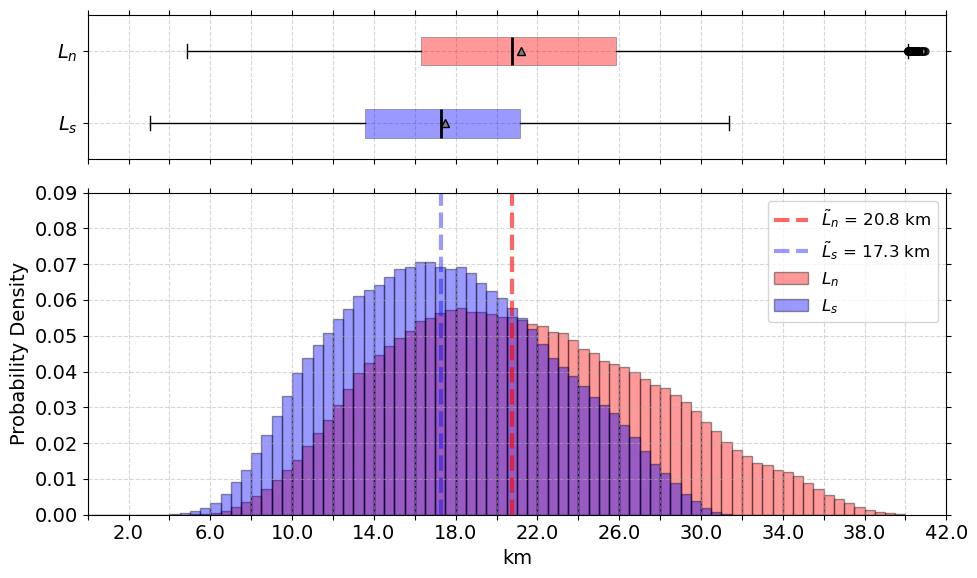

In [21]:
# Create figure
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(3, 1, height_ratios=[1, 1, 1])  # 3 rows, 1 column

# Set axes
ax1 = fig.add_subplot(gs[0])       # Top subplot
ax2 = fig.add_subplot(gs[1:])      # Bottom subplot spans rows 2 and 3

#--- Subplot 1 ---# 

bp = ax1.boxplot([Ls.flatten(), Ln.flatten()],vert=False, patch_artist=True, widths=0.4, showmeans=True,
            flierprops=dict(marker='o',     
                            markeredgecolor='k',      
                            #markerfacecolor='r',  
                            markersize=5,
                            linestyle='none', 
                            linewidth=0.5,
                            alpha=0.8), 
            medianprops=dict(linestyle='-',linewidth=2,color='k'), 
            boxprops=dict(color='k',          # Edge color
                          facecolor='blue',
                          linewidth=0.5,           # Border thickness
                          linestyle='-',
                          alpha=0.4), 
            whiskerprops=dict(linewidth=1, 
                              color= 'k', 
                              linestyle='-'), 
            meanprops=dict(color='gray',
                           markerfacecolor='gray',
                           markeredgecolor='k',
                           linewidth='0.5'
            ))

# Change individual box colors
colors = ['blue', 'red']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)

# Set figure attributes
ax1.set_xlim((0,42))
ax1.xaxis.set_major_locator(MultipleLocator(2))
xticks = ax1.get_xticks()
ax1.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)
ax1.set_xticklabels([])
ax1.set_yticklabels([r'$L_s$', r'$L_n$'])

#--- Subplot 2 ---# 

# Plot histogram
ax2.bar(bin_centers_Ln, pdf_Ln, width=bin_width, edgecolor='black', color='red', align='center', alpha=0.4, label=r'$L_n$')
ax2.bar(bin_centers_Ls, pdf_Ls, width=bin_width, edgecolor='black', color='blue', align='center', alpha=0.4, label=r'$L_s$')

# Plot statistics
ax2.axvline(Ln_median,color='red',alpha=0.6,linestyle='--',linewidth=3, label=r'$\tilde{L}_n$ = ' + str(np.round(Ln_median,1)) + ' km')
ax2.axvline(Ls_median,color='blue',alpha=0.4,linestyle='--',linewidth=3, label=r'$\tilde{L}_s$ = ' + str(np.round(Ls_median,1)) + ' km')

# Set figure attributes
ax2.set_xlabel(r'km')
ax2.set_ylabel('Probability Density')
ax2.set_xlim((0,42))
ax2.set_ylim((0,0.09))
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_major_locator(MultipleLocator(0.01))
xticks = ax2.get_xticks()
ax2.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
ax2.tick_params(axis='both', labelsize=14)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(fontsize=fontsize-2)
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

plt.tight_layout()
plt.show()

Compute a 1D pdf of the along decorrelation length scales for the ENTIRE time series in each of the regimes (off-shelf, shelf break, on-shelf)

In [44]:
# Set bin width and edges
bin_width = 0.5
bin_edges = np.arange(0,40+bin_width,bin_width)

# Define the regimes 
idx_off   = n_coord > 0
idx_trans = (n_coord >= -10) & (n_coord <= 10)
idx_on    = n_coord <= 0

# Set the data array for each regime
Ls_off   = Ls[:,idx_off]
Ls_trans = Ls[:,idx_trans]
Ls_on    = Ls[:,idx_on]

# Redefine the n-coordinate for each domain 
n_off   = n_coord[idx_off]
n_trans = n_coord[idx_trans]
n_on    = n_coord[idx_on]

# Compute histograms for along and cross isobath length scales
_, pdf_Ls_off, bin_centers_Ls_off     = stats.compute_pdf_1D(Ls_off.flatten(),bin_edges)
_, pdf_Ls_trans, bin_centers_Ls_trans = stats.compute_pdf_1D(Ls_trans.flatten(),bin_edges)
_, pdf_Ls_on, bin_centers_Ls_on       = stats.compute_pdf_1D(Ls_on.flatten(),bin_edges)

# Compute the statistics of each distribution

#--- off-shelf ---%
Ls_off_mean   = np.mean(Ls_off)
Ls_off_median = np.median(Ls_off)
Ls_off_perc   = np.percentile(Ls_off, 99)
Ls_off_std    = np.std(Ls_off,ddof=1)

#--- Shelf-break ---%
Ls_trans_mean   = np.mean(Ls_trans)
Ls_trans_median = np.median(Ls_trans)
Ls_trans_perc   = np.percentile(Ls_trans, 99)
Ls_trans_std    = np.std(Ls_trans,ddof=1)

#--- on-shelf ---%
Ls_on_mean   = np.mean(Ls_on)
Ls_on_median = np.median(Ls_on)
Ls_on_perc   = np.percentile(Ls_on, 99)
Ls_on_std    = np.std(Ls_on,ddof=1)

Plot histograms

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_941/4122566157.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_941/4122566157.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])


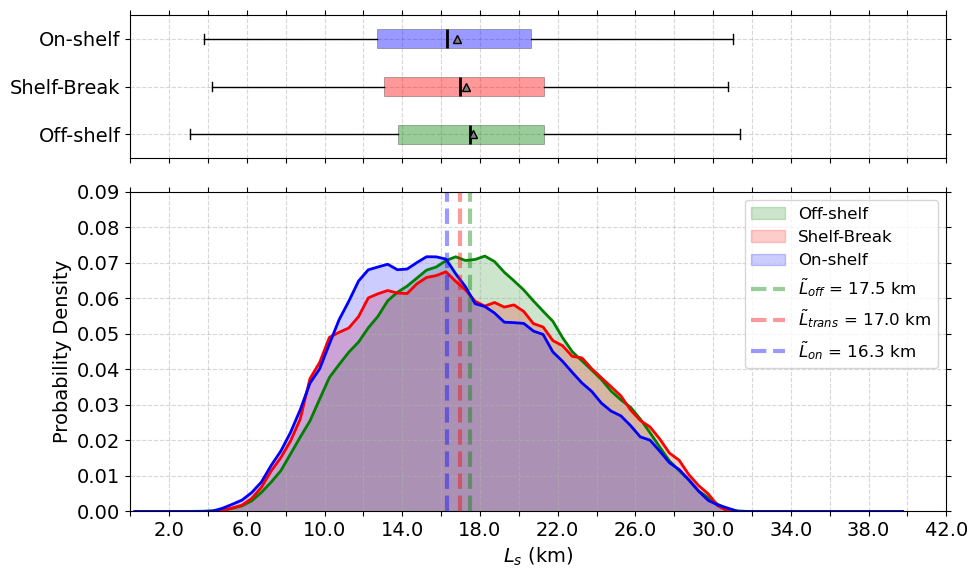

In [45]:
# Create figure
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(3, 1, height_ratios=[1, 1, 1])  # 3 rows, 1 column

# Set axes
ax1 = fig.add_subplot(gs[0])       # Top subplot
ax2 = fig.add_subplot(gs[1:])      # Bottom subplot spans rows 2 and 3

#--- Subplot 1 ---# 

bp = ax1.boxplot([Ls_off.flatten(), Ls_trans.flatten(), Ls_on.flatten()],vert=False, patch_artist=True, widths=0.4, showmeans=True,
            flierprops=dict(marker='o',     
                            markeredgecolor='k',      
                            #markerfacecolor='r',  
                            markersize=5,
                            linestyle='none', 
                            linewidth=0.5,
                            alpha=0.8), 
            medianprops=dict(linestyle='-',linewidth=2,color='k'), 
            boxprops=dict(color='k',          # Edge color
                          facecolor='blue',
                          linewidth=0.5,           # Border thickness
                          linestyle='-',
                          alpha=0.4), 
            whiskerprops=dict(linewidth=1, 
                              color= 'k', 
                              linestyle='-'), 
            meanprops=dict(color='gray',
                           markerfacecolor='gray',
                           markeredgecolor='k',
                           linewidth='0.5'
            ))

# Change individual box colors
colors = ['green', 'red', 'blue']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)

# Set figure attributes
ax1.set_xlim((0,42))
ax1.xaxis.set_major_locator(MultipleLocator(2))
xticks = ax1.get_xticks()
ax1.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
ax1.tick_params(axis='both', labelsize=14)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)
ax1.set_xticklabels([])
ax1.set_yticklabels([r'Off-shelf', r'Shelf-Break', r'On-shelf'])

#--- Subplot 2 ---# 

# Plot histogram
ax2.plot(bin_centers_Ls_off, pdf_Ls_off,'-',color='green',linewidth=2)
ax2.plot(bin_centers_Ls_trans, pdf_Ls_trans,'-',color='red',linewidth=2)
ax2.plot(bin_centers_Ls_on, pdf_Ls_on,'-',color='blue',linewidth=2)
ax2.fill_between(bin_centers_Ls_off, pdf_Ls_off, color='green', alpha=0.2, label='Off-shelf')
ax2.fill_between(bin_centers_Ls_trans, pdf_Ls_trans, color='red', alpha=0.2, label='Shelf-Break')
ax2.fill_between(bin_centers_Ls_on, pdf_Ls_on, color='blue', alpha=0.2, label='On-shelf')

# ax2.bar(bin_centers_Ls_off, pdf_Ls_off, width=bin_width, edgecolor='black', color='green', align='center', alpha=0.2, label=r'Off-shelf')
# ax2.bar(bin_centers_Ls_trans, pdf_Ls_trans, width=bin_width, edgecolor='black', color='red', align='center', alpha=0.2, label=r'Shelf-break')
# ax2.bar(bin_centers_Ls_on, pdf_Ls_on, width=bin_width, edgecolor='black', color='blue', align='center', alpha=0.2, label=r'On-shelf')

# Plot statistics
ax2.axvline(Ls_off_median,color='green',alpha=0.4,linestyle='--',linewidth=3, label=r'$\tilde{L}_{off}$ = ' + str(np.round(Ls_off_median,1)) + ' km')
ax2.axvline(Ls_trans_median,color='red',alpha=0.4,linestyle='--',linewidth=3, label=r'$\tilde{L}_{trans}$ = ' + str(np.round(Ls_trans_median,1)) + ' km')
ax2.axvline(Ls_on_median,color='blue',alpha=0.4,linestyle='--',linewidth=3, label=r'$\tilde{L}_{on}$ = ' + str(np.round(Ls_on_median,1)) + ' km')

# Set figure attributes
ax2.set_xlabel(r'$L_s$ (km)')
ax2.set_ylabel('Probability Density')
ax2.set_xlim((0,42))
ax2.set_ylim((0,0.09))
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_major_locator(MultipleLocator(0.01))
xticks = ax2.get_xticks()
ax2.set_xticklabels([label if i % 2 == 0 else '' for i, label in enumerate(xticks)])
ax2.tick_params(axis='both', labelsize=14)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(fontsize=fontsize-2)
ax2.tick_params(top=True, bottom=True, left=True, right=True,
               direction='out', length=3.5)

plt.tight_layout()
plt.show()